## 基本系統設置(本地執行)

In [ ]:
# # 更改繁體中文語系
!chcp 65001
# !chcp 437

Active code page: 65001


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
# 安裝必須設置
import sys
import subprocess
import pkg_resources

required = {'kaggle', 'tensorflow'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

C:\Users\112033645\AppData\Local\Temp\ipykernel_19192\2115042831.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


## 資料集準備

### 使用學姊資料

In [ ]:
# api token download data
import json
import os
import subprocess

# Define the API token for Kaggle authentication
api_token = {"username": "pinhsuanlee", "key": "28c330210349e9af127aaf6f88dfa39f"}

# Specify the directory where the Kaggle data will be stored
data_dir = "kaggle_data"

# Construct the path for the Kaggle API credentials file
api_js_file = os.path.join(data_dir, "kaggle.json")  # Removed the leading slash from the file name

# Create the data directory if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Write the API token to the credentials file
with open(api_js_file, 'w') as file:
    json.dump(api_token, file)

# Set the file permissions to read and write for the owner (600 in octal)
os.chmod(api_js_file, 0o600)

# Set the environment variable for the Kaggle configuration directory
os.environ['KAGGLE_CONFIG_DIR'] = data_dir

# Download the specified Kaggle dataset using the Kaggle API
subprocess.run(["kaggle", "datasets", "download", "-d", "pinhsuanlee/t-max-sxv1", "--force"])  # Corrected 'runn' to 'run'

# List the contents of the data directory and print them
print(os.listdir(data_dir))


['kaggle.json']


In [ ]:
# 解壓縮資料集
import zipfile

zip_data = 't-max-sxv1.zip'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if os.path.exists(zip_data):
    with zipfile.ZipFile(zip_data, 'r') as zip_ref: # 解壓縮
        zip_ref.extractall(data_dir)

### 使用學長資料

#### 本地端

In [ ]:
!cd

f:\Code\Embryo-Hyperspectral-DL-Recognition-System


In [ ]:
data_dir = os.getcwd()

#### 雲端

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 準備資料

In [1]:
from pathlib import Path

# data_dir = Path("/content/drive/MyDrive/Code/Project/Embryo-Hyperspectral-DL-Recognition-System")
data_dir = Path(r"F:\Code\Embryo-Hyperspectral-DL-Recognition-System")

all_data_path = data_dir / 'dataset'

test_dir = all_data_path / 'test_set'
test_good_dir = test_dir / 'good'
test_bad_dir = test_dir / 'bad'
train_dir = all_data_path / 'training_set'
train_good_dir = train_dir / 'good'
train_bad_dir = train_dir / 'bad'

In [2]:
train_dir.as_posix(), test_dir.as_posix()

('F:/Code/Embryo-Hyperspectral-DL-Recognition-System/dataset/training_set',
 'F:/Code/Embryo-Hyperspectral-DL-Recognition-System/dataset/test_set')

In [3]:
import os
# 基本資料數量
def img_num_in_dir(dir_path):
    return len(os.listdir(dir_path))

print(
f"""
There are:
    {img_num_in_dir(train_good_dir)} good picture for training,
    {img_num_in_dir(train_bad_dir)} bad picture for training,
    {img_num_in_dir(test_good_dir)} good picture for testing,
    {img_num_in_dir(test_bad_dir)} bad picture for testing.
"""
)


There are:
    74 good picture for training,
    74 bad picture for training,
    8 good picture for testing,
    9 bad picture for testing.



In [4]:
32/42, 8/10

(0.7619047619047619, 0.8)

## 資料夾圖像擴增
為了能讓訓練資料及平衡


In [5]:
import os
import tensorflow as tf
import datetime
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

def augment_image(image_path, augmentation_fn):
    """對單個圖像進行擴增並儲存擴增後的圖像。

    參數:
        image_path (str): 原始圖像的路徑。
        save_dir (str): 儲存擴增圖像的目錄。
        augmentation_fn (callable): 用於擴增圖像的函數
    """
    image = load_img(image_path, color_mode="grayscale")
    image = img_to_array(image)
    image = tf.expand_dims(image, 0)

    augument_image = augmentation_fn(image)
    return tf.squeeze(augument_image, 0)

def save_image_to_dir(image_path, image, save_dir):
    # 在文件名中添加一个随机数以避免重复
    minute = datetime.datetime.now().minute
    save_path = os.path.join(save_dir, f"aug_{minute}_{os.path.basename(image_path)}")
    save_img(save_path, image.numpy())

data_augmetation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

target_dir = train_good_dir
compare_dir = train_bad_dir
names = os.listdir(target_dir)

# 持续增强和保存图像直到两个目录的图像数量相等
while len(os.listdir(target_dir)) < len(os.listdir(compare_dir)):
    for image_name in names:
        image_path = os.path.join(target_dir, image_name)
        img = augment_image(image_path, data_augmetation)
        save_image_to_dir(image_path, img, target_dir)
        if len(os.listdir(target_dir)) >= len(os.listdir(compare_dir)):
            break

print(
    f"""
    There are:
        {img_num_in_dir(train_good_dir)} good picture for training,
        {img_num_in_dir(train_bad_dir)} bad picture for training,
        {img_num_in_dir(test_good_dir)} good picture for testing,
        {img_num_in_dir(test_bad_dir)} bad picture for testing.
    """
)




    There are:
        74 good picture for training,
        74 bad picture for training,
        8 good picture for testing,
        9 bad picture for testing.
    


## 圖片基本性質

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [7]:
[dir.parent.name for dir in test_bad_dir.iterdir()]

['bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad']

In [8]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def image_path_2_iamge(image_paths):
    images = []
    labels = []
    for image_path in image_paths:
        img = np.asarray(Image.open(image_path))
        images.append(img)
        label = image_path.parent.name
        labels.append(label)
    return images, labels

def square_show_images(images, labels, cmap="gray", titles=None, colorbar=False):
    """
    Display images in a grid with their parent directory name as the title.

    Parameters:
    - images: list of images.
    - labels: list of labels.
    - cmap: color map for displaying images.
    - titles: list of titles for each subplot.
    - colorbar: boolean to determine if colorbar should be shown.
    """

    # 設置子圖行數和列數
    column_number = int(np.sqrt(len(images)))
    row_number = int(np.ceil(len(images) / column_number))
    fig_size = (column_number * 3, row_number * 3)

    fig, axs = plt.subplots(row_number, column_number, figsize=fig_size)

    # 確保 axs 始終是二維的
    if row_number == 1:
        axs = np.expand_dims(axs, axis=0)  # 將 axs 轉換為二維陣列

    for i in range(len(images)):
        label = labels[i]
        img = images[i]

        ax = axs[i // column_number, i % column_number]
        aximg = ax.imshow(img, cmap=cmap)
        ax.set_title(label if not titles else titles[i])
        ax.axis('off')
        
        if colorbar:
            fig.colorbar(aximg, ax=ax, fraction=0.046, pad=0.04)

    # 將多出來的子圖設置為空
    for i in range(len(images), row_number * column_number):
        ax = axs[i // column_number, i % column_number]
        ax.axis('off')

    plt.show()

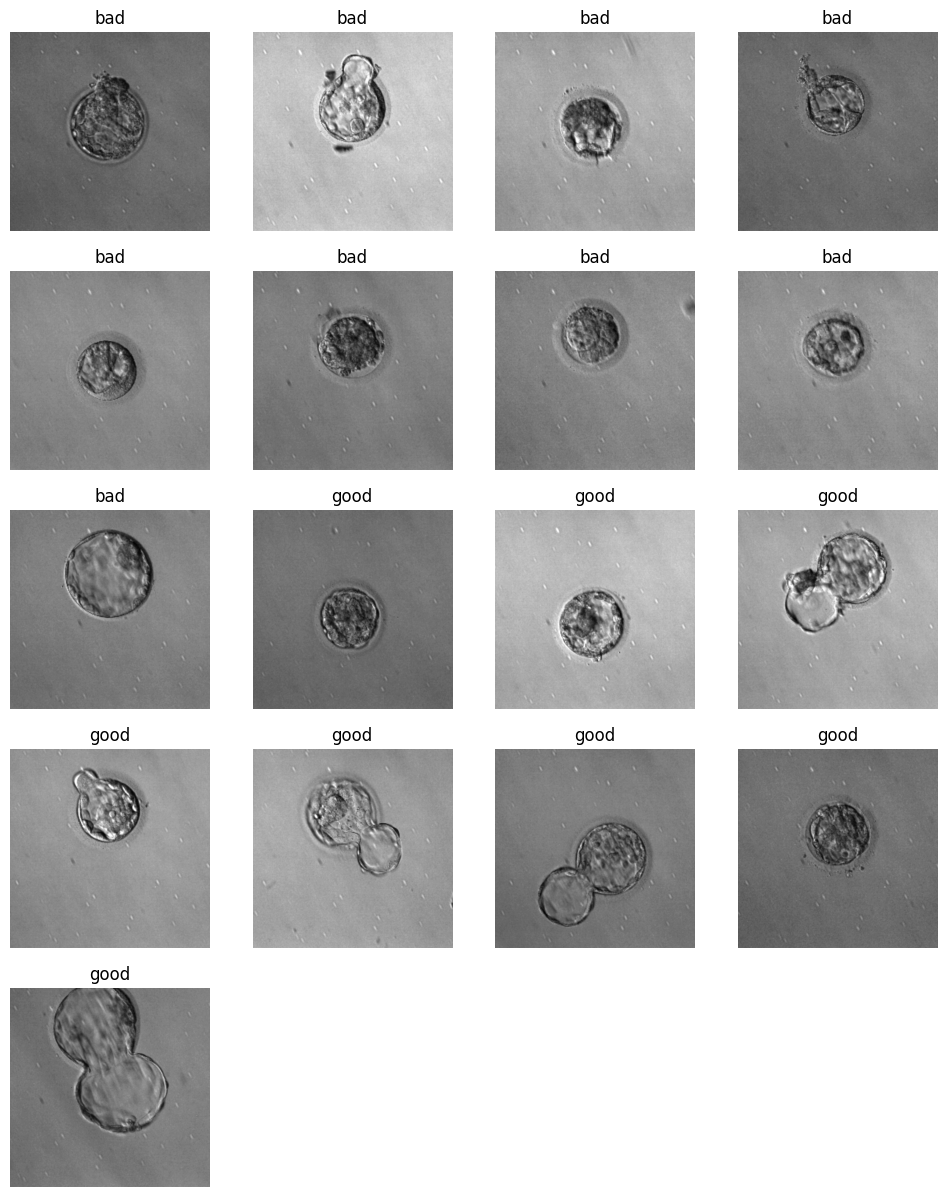

In [9]:
test_bad_image_paths = [img for img in test_bad_dir.iterdir() if img.suffix in ('.png', '.jpg', '.jpeg')]
test_good_image_paths = [img for img in test_good_dir.iterdir() if img.suffix in ('.png', '.jpg', '.jpeg')]
test_image_paths = test_bad_image_paths + test_good_image_paths

# 顯示圖片
test_images, test_labels = image_path_2_iamge(test_image_paths)
square_show_images(test_images, test_labels)

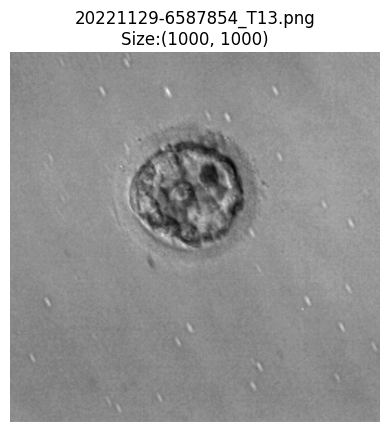

In [10]:
# 了解隨機圖像的資訊
import random
sample_image_path = random.choice(test_image_paths)
sample_image = Image.open(sample_image_path)
plt.imshow(sample_image, cmap='gray')
plt.title(f"{sample_image_path.name}\nSize:{sample_image.size}")
plt.axis('off')
plt.show()

In [11]:
sample_array = np.array(sample_image)
sample_array.max(), sample_array.min()

(193, 44)

## 創建訓練資料集

In [12]:
import tensorflow as tf

# 設定資料集參數
batch_size = 2
img_height = 700
img_width = 700

# 從目錄創建訓練資料集
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,  # 訓練資料集的目錄
    labels='inferred',          # 從子資料夾名稱推斷標籤
    label_mode='binary',        # 二元分類
    color_mode='grayscale',     # 灰階圖像
    batch_size=batch_size,
    image_size=(img_height, img_width),  # 調整圖像大小
    shuffle=True,               # 打亂資料
)
# 從目錄創建訓練資料集
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,  # 訓練資料集的目錄
    labels='inferred',          # 從子資料夾名稱推斷標籤
    label_mode='binary',        # 二元分類
    color_mode='grayscale',     # 灰階圖像
    batch_size=batch_size,
    image_size=(img_height, img_width),  # 調整圖像大小
)

# 設定預處理層
normalization_layer = tf.keras.layers.Rescaling(1./255)  # 將像素值歸一化到 [0,1]
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# 設定資料集性能參數
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 148 files belonging to 2 classes.
Found 17 files belonging to 2 classes.


In [13]:
# 收集測試標籤
y_labels = []
for images, labels in test_ds:
    y_labels.append(labels)
y_labels = tf.concat(y_labels, axis=0)

class_names = sorted(os.listdir(train_dir))
y_labels, class_names

(<tf.Tensor: shape=(17, 1), dtype=float32, numpy=
 array([[0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.]], dtype=float32)>,
 ['bad', 'good'])

In [14]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

!curl https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py -o helper_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10246  100 10246    0     0  22651      0 --:--:-- --:--:-- --:--:-- 22819


## 建立模型

### 學姊的模型

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

def senior_sister_net():
    '''學姊的神經網路架構，除了最終輸出是2class之外
    '''
    inputs = tf.keras.layers.Input(shape=(700, 700, 1))
    x = layers.Conv2D(filters=20, kernel_size=13, strides=4, activation='relu')(inputs)
    # x = layers.AveragePooling2D()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(filters=30, kernel_size=13, strides=4, activation='relu')(x)
    # x = layers.AveragePooling2D()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(units=1000, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs=inputs, outputs=outputs)

# Create an instance of the model
net = senior_sister_net()

# Compile the model
net.compile(optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
            loss=losses.BinaryCrossentropy(),
            metrics=['accuracy'])

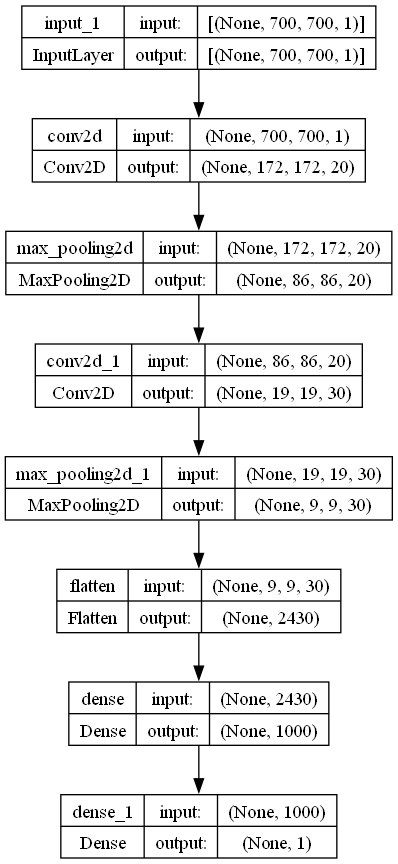

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(net, show_shapes=True, show_layer_names=True, to_file='model.png')

In [17]:
for prints in [(layer.name, layer.output.shape[1:3]) for layer in net.layers ]:
    print(prints)

('input_1', TensorShape([700, 700]))
('conv2d', TensorShape([172, 172]))
('max_pooling2d', TensorShape([86, 86]))
('conv2d_1', TensorShape([19, 19]))
('max_pooling2d_1', TensorShape([9, 9]))
('flatten', TensorShape([2430]))
('dense', TensorShape([1000]))
('dense_1', TensorShape([1]))


In [18]:
current_size = 700
for i in range(10):
    current_size = np.floor(current_size - 13)//4 +1
    print(f"Conv{i+1} output: {current_size:.0f}x{current_size:.0f}")
    # current_size /= 2
    # current_size = np.floor(current_size)
    # print(f"MaxPool{i+1} output: {current_size:.0f}x{current_size:.0f}")

Conv1 output: 172x172
Conv2 output: 40x40
Conv3 output: 7x7
Conv4 output: -1x-1
Conv5 output: -3x-3
Conv6 output: -3x-3
Conv7 output: -3x-3
Conv8 output: -3x-3
Conv9 output: -3x-3
Conv10 output: -3x-3


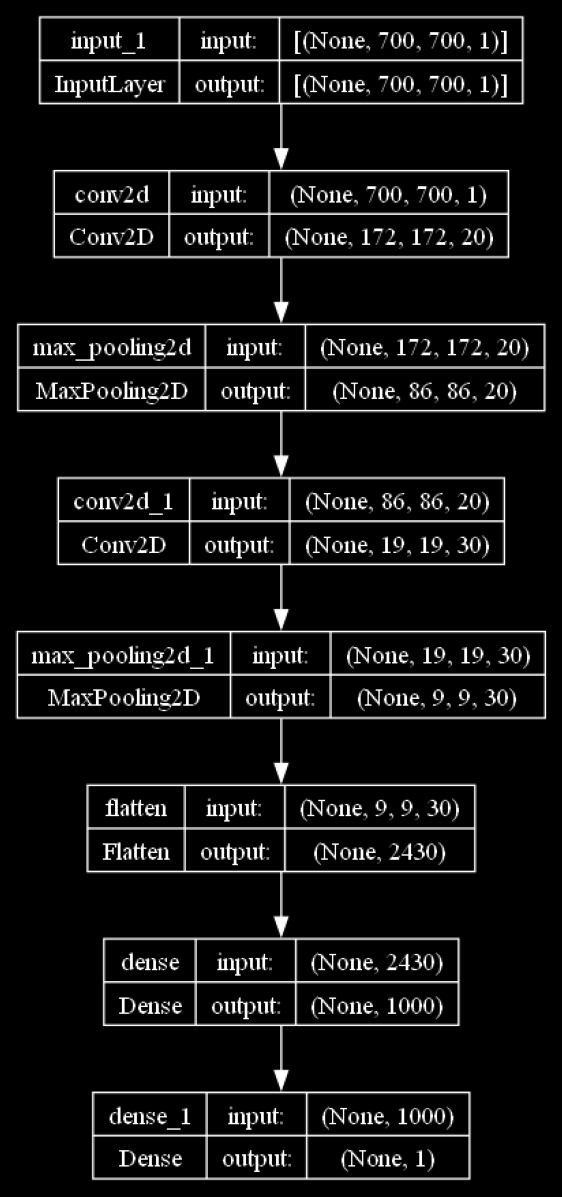

In [19]:
import cv2

# 讀取圖片
img = cv2.imread('model.png', cv2.IMREAD_GRAYSCALE)

# 反轉像素值
negative_img = cv2.bitwise_not(img)

# 顯示負片效果的圖片
plt.figure(figsize=(img.shape[1]//50, img.shape[0]//50), facecolor='black')
plt.imshow(negative_img, cmap='gray')
plt.axis('off')
plt.show()

In [20]:
input_shape = (700, 700, 1)
net.build(input_shape)

# Train the model
history = net.fit(
      train_ds,
      epochs=30,
      validation_data=test_ds)

Epoch 1/30


74/74 [==============================] - 3s 35ms/step - loss: 0.6981 - accuracy: 0.4527 - val_loss: 0.6946 - val_accuracy: 0.4706
Epoch 2/30
74/74 [==============================] - 2s 23ms/step - loss: 0.6948 - accuracy: 0.4324 - val_loss: 0.6934 - val_accuracy: 0.4706
Epoch 3/30
74/74 [==============================] - 2s 24ms/step - loss: 0.6941 - accuracy: 0.4662 - val_loss: 0.6941 - val_accuracy: 0.4706
Epoch 4/30
74/74 [==============================] - 2s 23ms/step - loss: 0.6940 - accuracy: 0.3986 - val_loss: 0.6936 - val_accuracy: 0.4706
Epoch 5/30
74/74 [==============================] - 2s 23ms/step - loss: 0.6936 - accuracy: 0.4392 - val_loss: 0.6934 - val_accuracy: 0.4706
Epoch 6/30
74/74 [==============================] - 2s 25ms/step - loss: 0.6938 - accuracy: 0.4865 - val_loss: 0.6936 - val_accuracy: 0.4706
Epoch 7/30
74/74 [==============================] - 2s 23ms/step - loss: 0.6937 - accuracy: 0.4662 - val_loss: 0.6934 - val_accuracy: 0.4706
Epoch 8/30


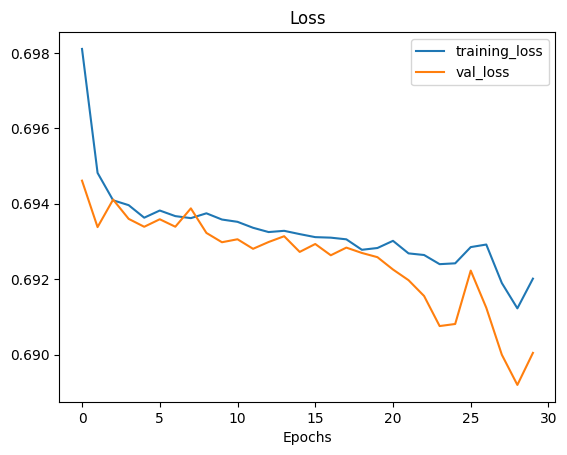

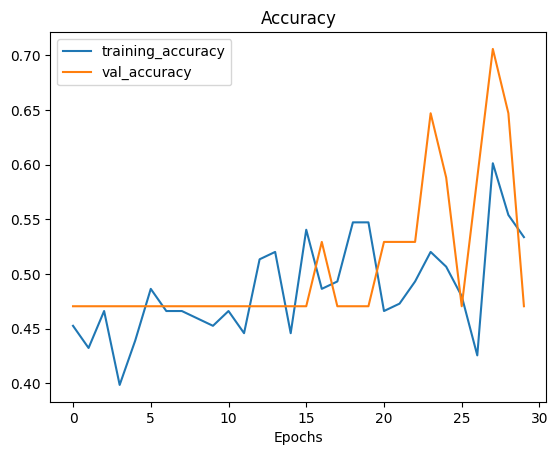

In [21]:
from helper_functions import plot_loss_curves
plot_loss_curves(history)

In [22]:
y_pred_probs = net.predict(test_ds)

9/9 [==============================] - 0s 6ms/step


In [23]:
y_preds = (y_pred_probs > 0.5).astype(int)
y_preds

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

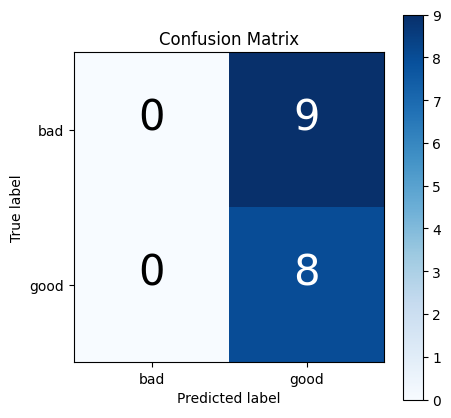

In [24]:
from helper_functions import make_confusion_matrix
make_confusion_matrix(y_true=y_labels, y_pred=y_preds, classes=class_names, figsize=(5, 5), text_size=30, norm=False, savefig=False)

### 模型1
簡單四層Conv+MaxPooling

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses

inputs = tf.keras.layers.Input(shape=(700, 700, 1))
x = layers.Conv2D(filters=10, kernel_size=3, strides=2, activation='relu')(inputs)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(filters=15, kernel_size=3, strides=2, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(filters=20, kernel_size=3, strides=2, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(units=100, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=optimizers.Adam(),
              loss=losses.BinaryCrossentropy(from_logits=False),

              metrics=['accuracy'])

# Train the model
history_2 = model.fit(
      train_ds,
      epochs=30,
      validation_data=test_ds)

Epoch 1/30
64/64 [==============================] - 4s 11ms/step - loss: 0.6959 - accuracy: 0.4062 - val_loss: 0.6909 - val_accuracy: 0.8000
Epoch 2/30
64/64 [==============================] - 1s 9ms/step - loss: 0.6947 - accuracy: 0.3906 - val_loss: 0.6932 - val_accuracy: 0.3000
Epoch 3/30
64/64 [==============================] - 1s 9ms/step - loss: 0.6944 - accuracy: 0.3750 - val_loss: 0.6934 - val_accuracy: 0.2000
Epoch 4/30
64/64 [==============================] - 1s 8ms/step - loss: 0.6953 - accuracy: 0.4375 - val_loss: 0.6932 - val_accuracy: 0.7000
Epoch 5/30
64/64 [==============================] - 1s 9ms/step - loss: 0.6952 - accuracy: 0.4375 - val_loss: 0.6945 - val_accuracy: 0.2000
Epoch 6/30
64/64 [==============================] - 1s 9ms/step - loss: 0.6954 - accuracy: 0.4062 - val_loss: 0.6910 - val_accuracy: 0.8000
Epoch 7/30
64/64 [==============================] - 1s 8ms/step - loss: 0.6942 - accuracy: 0.4531 - val_loss: 0.6941 - val_accuracy: 0.2000
Epoch 8/30
64/64 [=

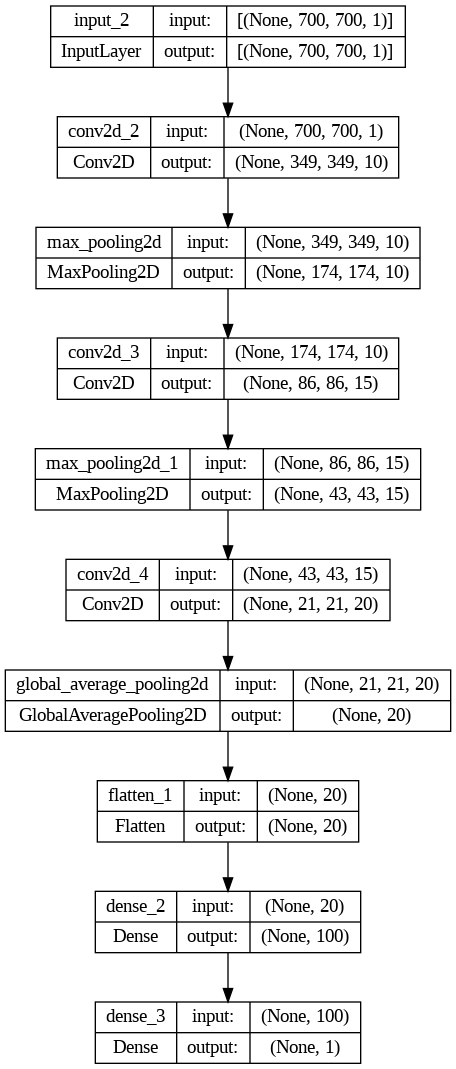

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

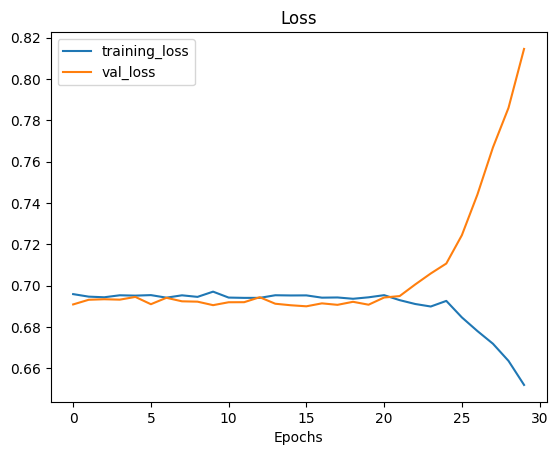

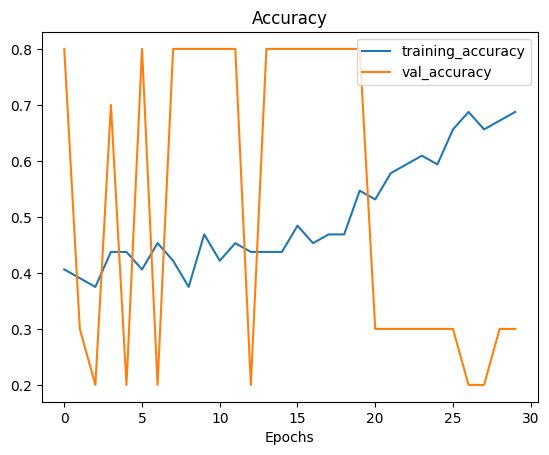

In [ ]:
plot_loss_curves(history_2)

In [ ]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 700, 700, 1)]     0         
                                                                 
 conv2d_27 (Conv2D)          (None, 349, 349, 20)      200       
                                                                 
 max_pooling2d (MaxPooling2  (None, 174, 174, 20)      0         
 D)                                                              
                                                                 
 conv2d_28 (Conv2D)          (None, 86, 86, 20)        3620      
                                                                 
 global_average_pooling2d (  (None, 20)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten_8 (Flatten)         (None, 20)                0   

## save model

In [25]:
save_name = 'seneior_sister_model_20240702_epoch30_maxpooling'
save_folder = data_dir
save_path = os.path.join(save_folder, save_name)
net.save(save_path)

INFO:tensorflow:Assets written to: F:\Code\Embryo-Hyperspectral-DL-Recognition-System\seneior_sister_model_20240702_epoch30_maxpooling\assets


INFO:tensorflow:Assets written to: F:\Code\Embryo-Hyperspectral-DL-Recognition-System\seneior_sister_model_20240702_epoch30_maxpooling\assets


In [38]:
## save_test
load_name = "seneior_sister_model_20240702_epoch30_averagepoling"
load_folder = data_dir
load_path = os.path.join(load_folder, load_name)
loaded_model = tf.keras.models.load_model(load_path)
loaded_model.predict(test_ds) == net.predict(test_ds), loaded_model.predict(test_ds)

9/9 [==============================] - 0s 6ms/step


(array([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]]),
 array([[0.49910334],
        [0.49782735],
        [0.49971533],
        [0.49925888],
        [0.49891868],
        [0.4983503 ],
        [0.49821246],
        [0.4996339 ],
        [0.4986488 ],
        [0.49835625],
        [0.49818474],
        [0.49993217],
        [0.49939522],
        [0.49817246],
        [0.4990083 ],
        [0.4990874 ],
        [0.4989708 ]], dtype=float32))

## Visaulize CNN

### Attention map
查看目前神經網路特別關注何處
參考代碼: https://colab.research.google.com/github/zaidalyafeai/AttentioNN/blob/master/Attention_Maps.ipynb

In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random
import tensorflow as tf

# 預處理函數
def preprocess(img_path, target_size):
    img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale', target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    return np.expand_dims(img, 0)

# 後處理激活
def postprocess_activations(activations, target_size):
    output = np.abs(activations)
    output = np.sum(output, axis=-1).squeeze()
    output = cv2.resize(output, target_size)
    output /= output.max()
    output *= 255
    return output.astype('uint8')

# 應用熱圖
def apply_heatmap(weights, img):
    heatmap = cv2.applyColorMap(weights, cv2.COLORMAP_JET)
    heatmap = cv2.addWeighted(heatmap, 0.7, img, 0.3, 0)
    return heatmap

# 繪製熱圖
def generate_heatmap(img_path, target_size, model, layer_index):
    input_img = preprocess(img_path, target_size)
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    intermediate_model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[layer_index].output)
    activations = intermediate_model.predict(input_img)
    weights = postprocess_activations(activations, target_size)
    heatmap = apply_heatmap(weights, img)

    return heatmap

1/1 [==============================] - 0s 73ms/step


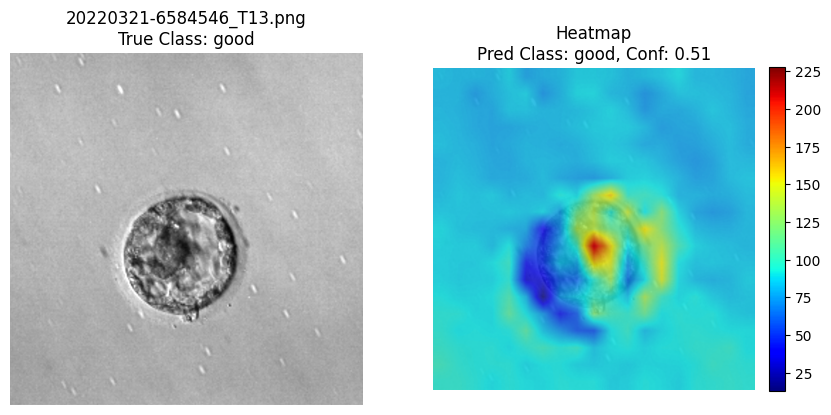

In [27]:
# 設定參數
layer_index = 3
select_model = net
target_size = (700, 700)

# 隨機選擇一個樣本文件
sample = random.choice(test_image_paths)
sample_img = plt.imread(str(sample))

# 繪製熱圖
heatmap_img = generate_heatmap(img_path=str(sample), target_size=target_size, model=select_model, layer_index=layer_index)

# 預測並顯示結果
pred_probs = net.predict(preprocess(img_path=str(sample), target_size=(700, 700)))
pred_confidence = pred_probs[0, 0]  # 獲取概率值
pred_class = 'good' if pred_confidence > 0.5 else 'bad'  # 判斷類別
true_class = sample.parent.name  # 真實類別

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# 顯示樣本圖像
ax[0].imshow(sample_img, cmap="gray")
ax[0].set_title(f"{sample.name}\nTrue Class: {true_class}")
ax[0].axis('off')

# 顯示熱圖
heatmap  = ax[1].imshow(heatmap_img, cmap="jet")
ax[1].set_title(f"Heatmap\nPred Class: {pred_class}, Conf: {pred_confidence:.2f}")
ax[1].axis('off')

fig.colorbar(heatmap, ax=ax[1], fraction=0.046, pad=0.04)

plt.show()


In [26]:
net.input, net.output

(<KerasTensor: shape=(None, 700, 700, 1) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>)

In [27]:
[layer.name for layer in net.layers]

['input_1',
 'conv2d',
 'average_pooling2d',
 'conv2d_1',
 'average_pooling2d_1',
 'flatten',
 'dense',
 'dense_1']

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 22ms/step


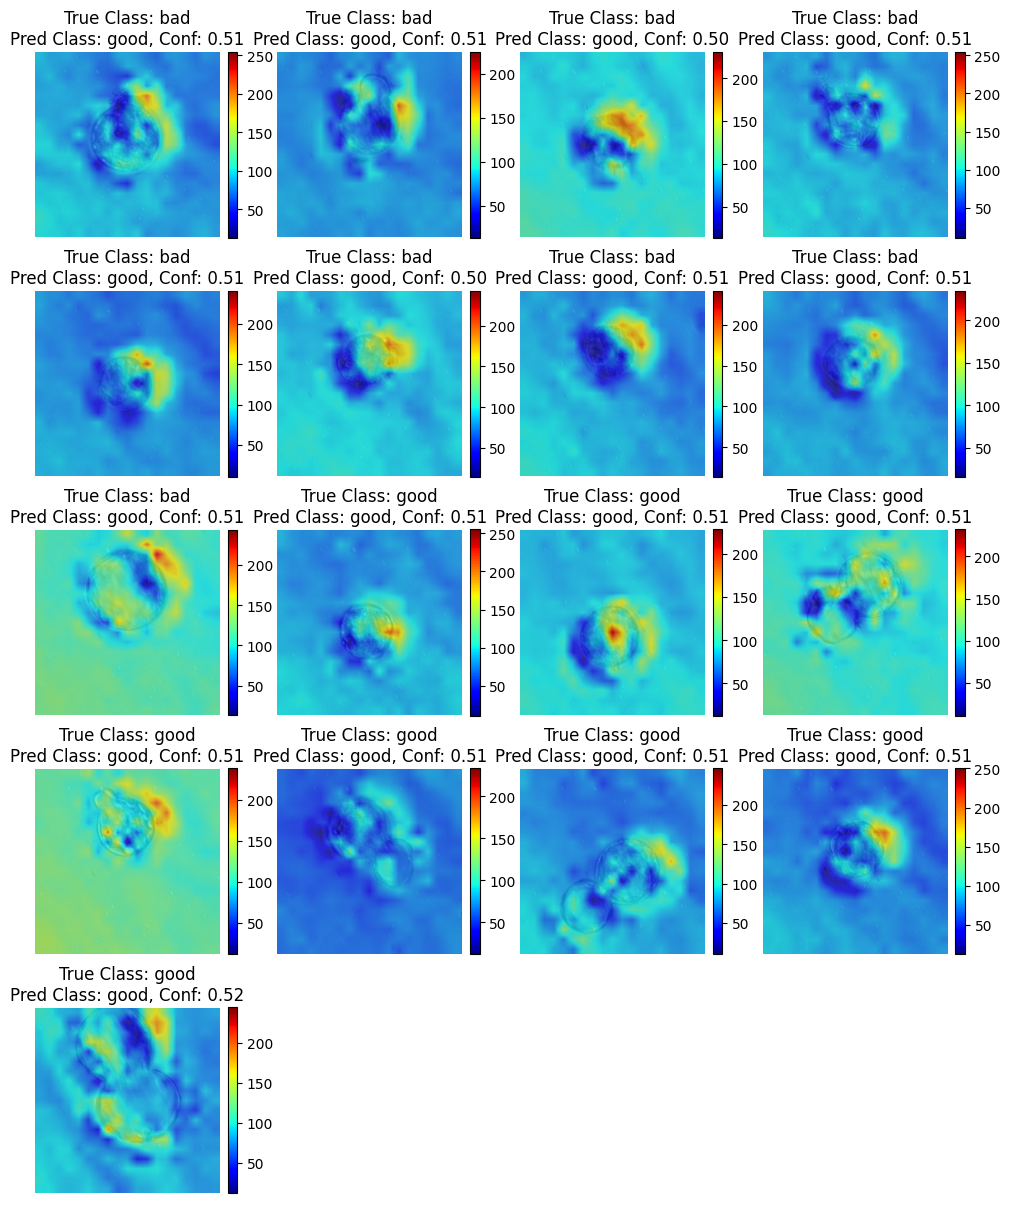

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 設定參數
layer_index = 3
select_model = net
target_size = (700, 700)

heatmap_images = []
titles = []
true_labels = [image_path.parent.name for image_path in test_image_paths]
pred_labels = []

# 處理每張測試影像
for i in range(len(test_image_paths)):
    image_path = test_image_paths[i]
    image = plt.imread(str(image_path))

    # 生成熱圖
    heatmap_image = generate_heatmap(img_path=str(image_path), target_size=target_size, model=select_model, layer_index=layer_index)
    heatmap_images.append(heatmap_image)

    # 預測並顯示結果
    pred_probs = select_model.predict(preprocess(img_path=str(image_path), target_size=target_size))
    pred_confidence = pred_probs[0, 0]
    pred_class = 'good' if pred_confidence > 0.5 else 'bad'  # 假設 'good' 和 'bad' 是類別名稱
    pred_labels.append(pred_class)

    # 設置標題
    title = f"True Class: {true_labels[i]}\nPred Class: {pred_class}, Conf: {pred_confidence:.2f}"
    titles.append(title)

# 顯示熱圖和標題
square_show_images(heatmap_images, pred_labels,cmap="jet", titles=titles, colorbar=True)


In [29]:
# 測試資料集預測
test_pred_probs = select_model.predict(test_ds)
test_pred_labels = ['good' if prob > 0.5 else 'bad' for prob in test_pred_probs]
print(test_pred_labels)
print(y_labels)
print(test_pred_probs)
print(y_preds)

9/9 [==============================] - 0s 8ms/step
['bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad', 'bad']
tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]], shape=(17, 1), dtype=float32)
[[0.49818474]
 [0.49782735]
 [0.4983503 ]
 [0.49821246]
 [0.49925888]
 [0.49835625]
 [0.49939522]
 [0.4990083 ]
 [0.4986488 ]
 [0.49910334]
 [0.4990874 ]
 [0.4989708 ]
 [0.49891868]
 [0.49971533]
 [0.49993217]
 [0.4996339 ]
 [0.49817246]]
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


## Grad-CAM

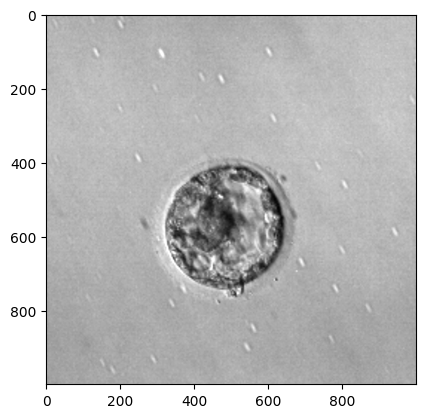

In [29]:
image = np.array(sample_img)
plt.imshow(image, cmap='gray')
plt.show()

In [39]:
# select_model = net
select_model = loaded_model
print("\n".join([f"{layer.name}: {layer.output.shape}" for layer in select_model.layers]))

input_1: (None, 700, 700, 1)
conv2d: (None, 172, 172, 20)
average_pooling2d: (None, 86, 86, 20)
conv2d_1: (None, 19, 19, 30)
average_pooling2d_1: (None, 9, 9, 30)
flatten: (None, 2430)
dense: (None, 1000)
dense_1: (None, 1)


In [31]:
net.input_shape

(None, 700, 700, 1)

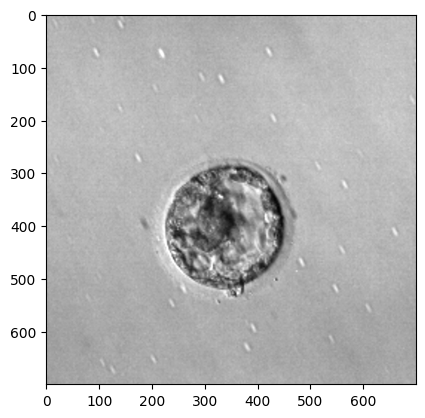

In [40]:
## Grad-CAM ##
# Assuming `sample_img` is a numpy array of shape (700, 700, 1)
# Replace `sample_img` with your actual image array
# sample_img = np.random.rand(700, 700, 1)  # Placeholder, replace with actual image

last_layer_from = -4

# image = np.array(sample_img)
if image.shape != (700, 700, 1):
    image = cv2.resize(image, (700, 700)).reshape((700, 700, 1))
plt.imshow(image.squeeze(), cmap='gray')
plt.show()

# Get the last convolutional layer
last_conv_layer = select_model.get_layer("conv2d_1")  # 使用層名稱來獲取最後一層卷積層
last_conv_layer_model = tf.keras.Model(select_model.inputs, last_conv_layer.output)

# Construct the classifier model up to the last convolutional layer
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer in select_model.layers[-4:]:  # 只保留卷積層之後的部分
    x = layer(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [41]:
# 確保 last_conv_layer_model 和 select_model 的關聯是正確的
with tf.GradientTape() as tape:
    inputs = image[np.newaxis, ...]
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    print(preds.shape)
    print(preds)
    top_class_channel = preds[:, 0]
    print(top_class_channel)

(1, 1)
tf.Tensor([[0.49939522]], shape=(1, 1), dtype=float32)
tf.Tensor([0.49939522], shape=(1,), dtype=float32)


In [42]:
# 取得梯度
grads = tape.gradient(top_class_channel, last_conv_layer_output)

# 確保梯度不為空
if grads is not None:
    print("Gradient calculation successful.")
else:
    print("Gradient is None. Check your setup.")
print(f"Select model input shape: {select_model.input_shape}")
print(f"Last convolutional layer output shape: {last_conv_layer_output.shape}")
print(f"select_model layer conv2d_3:{select_model.get_layer('conv2d_1').output.shape}")

Gradient calculation successful.
Select model input shape: (None, 700, 700, 1)
Last convolutional layer output shape: (1, 19, 19, 30)
select_model layer conv2d_3:(None, 19, 19, 30)


Grad-CAM for Class 0:


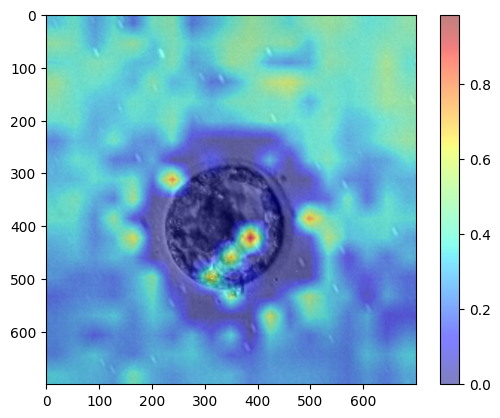

Grad-CAM for Class 1:


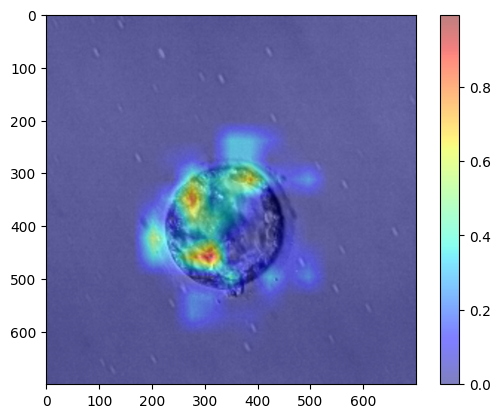

In [43]:
def generate_gradcam(inputs, class_channel):
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(inputs)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_class_channel = class_channel(preds)

    # 取得梯度
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # 確保梯度不為空
    if grads is not None:
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        last_conv_layer_output = last_conv_layer_output.numpy()[0]
        pooled_grads = pooled_grads.numpy()
        for i in range(pooled_grads.shape[-1]):
            last_conv_layer_output[:, :, i] *= pooled_grads[i]

        # 平均所有的濾波器，得到單一的2D陣列
        gradcam = np.mean(last_conv_layer_output, axis=-1)
        # 剪切值（相當於應用ReLU），然後正規化值
        gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
        gradcam = cv2.resize(gradcam, (700, 700))

        return gradcam
    else:
        print("Gradient computation failed.")
        return None

# 為兩個類別分別生成Grad-CAM圖像
gradcam_class_0 = generate_gradcam(inputs, lambda preds: 1 - preds[:, 0])  # 低於0.5是類別0
gradcam_class_1 = generate_gradcam(inputs, lambda preds: preds[:, 0])  # 超過0.5是類別1

# 可視化原始圖像和Grad-CAM
def visualize_gradcam(image, gradcam):
    plt.imshow(image.squeeze(), cmap="gray")
    plt.imshow(gradcam, alpha=0.5, cmap='jet')
    plt.colorbar()
    plt.show()

if gradcam_class_0 is not None:
    print("Grad-CAM for Class 0:")
    visualize_gradcam(image, gradcam_class_0)

if gradcam_class_1 is not None:
    print("Grad-CAM for Class 1:")
    visualize_gradcam(image, gradcam_class_1)

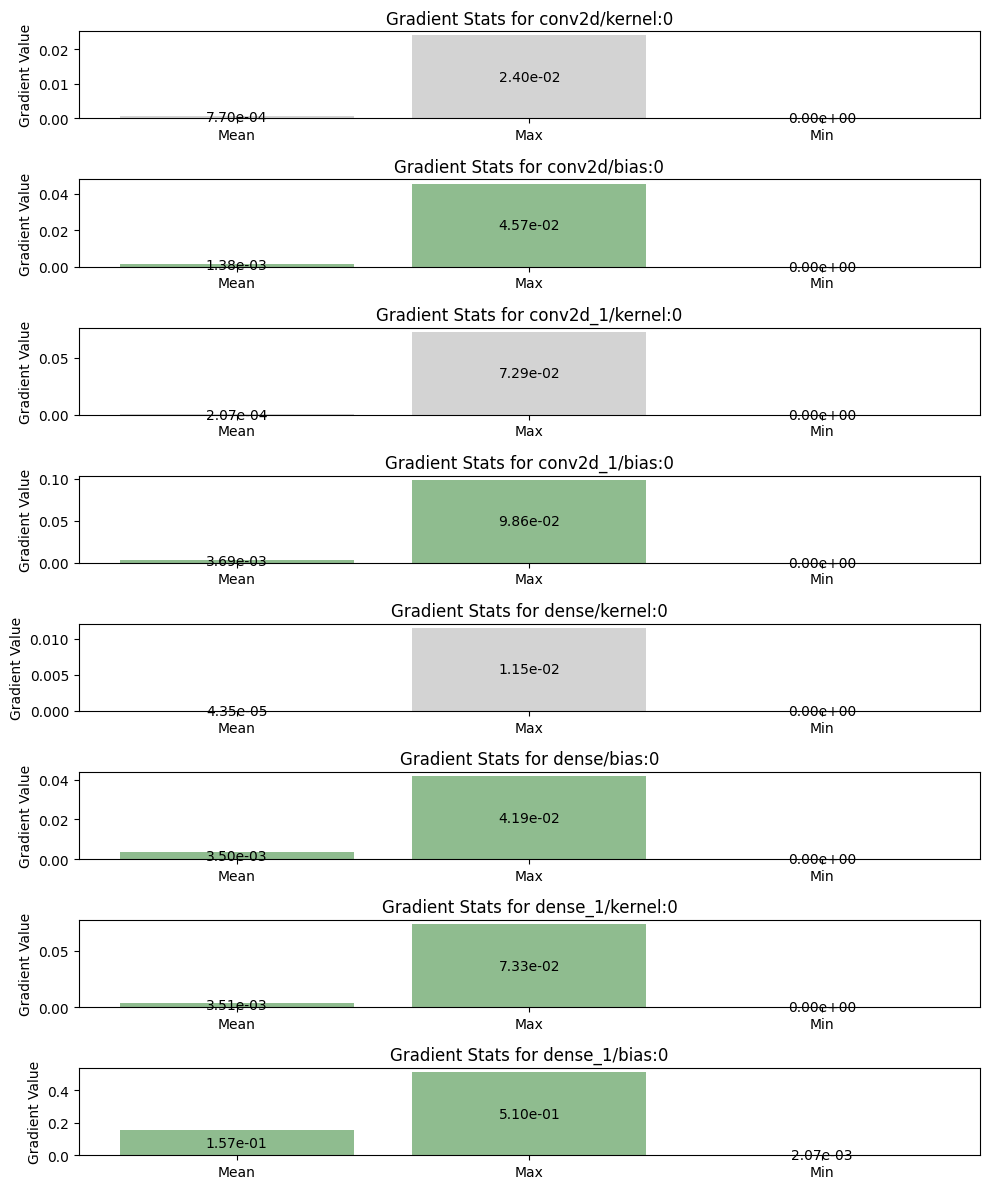

In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# 假設有一個損失函數
loss_fn = tf.keras.losses.BinaryCrossentropy()

# 定義一個梯度計算函數
def compute_gradients(model, x, y, loss_fn):
    with tf.GradientTape() as tape:
        # 前向傳播計算損失
        logits = model(x)
        loss = loss_fn(y, logits)
    # 使用 GradientTape 計算梯度
    gradients = tape.gradient(loss, model.trainable_variables)
    return gradients

# 假設 select_model 是您的模型
# 假設 train_ds 是您的訓練資料集描述
gradients_np = []
for x, y in train_ds.take(10):  # 取多個 batch 的資料
    gradients = compute_gradients(select_model, x, y, loss_fn)
    gradients_np.append([gradient.numpy() for gradient in gradients])

# 視覺化梯度
layer_names = [weight.name for layer in select_model.layers for weight in layer.weights]
fig, axs = plt.subplots(len(gradients_np[0]), figsize=(10, 12))  # 調整圖表大小

for i, layer_name in enumerate(layer_names):
    mean_grads = [np.mean(np.abs(grad[i])) for grad in gradients_np]
    max_grads = [np.max(np.abs(grad[i])) for grad in gradients_np]
    min_grads = [np.min(np.abs(grad[i])) for grad in gradients_np]

    mean_grad = np.mean(mean_grads)
    max_grad = np.max(max_grads)
    min_grad = np.min(min_grads)

    # 判斷是否梯度消失或梯度爆炸
    if mean_grad < 1e-3:
        color = 'lightgray'
    elif max_grad > 1:
        color = 'red'
    else:
        color = 'darkseagreen'
    
    bars = axs[i].bar(["Mean", "Max", "Min"], [mean_grad, max_grad, min_grad], color=color)
    
    # 在bar中間顯示值
    for bar, value in zip(bars, [mean_grad, max_grad, min_grad]):
        height = bar.get_height()
        axs[i].text(bar.get_x() + bar.get_width() / 2, height / 2, f'{value:.2e}', 
                    ha='center', va='center')
    
    axs[i].set_title(f'Gradient Stats for {layer_name}')
    axs[i].set_ylabel('Gradient Value')

plt.tight_layout()
plt.show()


In [100]:
select_model.input_shape, select_model.output_shape, train_ds

((None, 700, 700, 1),
 (None, 1),
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 700, 700, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>)

### Visualize CNN filter

In [ ]:
import matplotlib.image as mpimg
import math

In [ ]:
def make_random_image(img_height=700, img_width=700, shift=True):
  img = tf.random.uniform((1, img_width, img_height, 1))
  if shift:
    return (img -0.5) * 0.25
  return img * 0.25

In [ ]:
def convert_to_image(x: np.array):
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.15

  x += 0.5
  x = np.clip(x, 0, 1)

  x *= 255
  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
@tf.function
def gradient_ascent_filter(img, filter_index, step_size, model):
  with tf.GradientTape() as tape:
    tape.watch(img)

    activation = model(img)

    filter_activation = activation[:, 2:-2, 2:-2, filter_index]

    loss = tf.reduce_mean(filter_activation)

  grads = tape.gradient(loss, img)

  grads = tf.math.l2_normalize(grads)

  img += step_size * grads

  return img

In [ ]:
def visualize_filter(model, input_img, layer_name, filter_index, steps=50, step_size=10.0):
  img = input_img

  layer = model.get_layer(layer_name)

  feature_extractor = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)

  for iteration in range(steps):
    img = gradient_ascent_filter(img, filter_index, step_size, feature_extractor)

  img = convert_to_image(tf.squeeze(img).numpy())

  return img


In [ ]:
import random
from tqdm import tqdm

def visualize_filters(model, layer_name, max_filters=20, steps=80, step_size=10.0, shift=True):

  input_img = make_random_image(shift=shift)
  num_filter = model.get_layer(layer_name).output.shape[3]
  if max_filters >  num_filter:
    max_filters = num_filter

  print(f'Showing {max_filters} random filters in {layer_name}')

  plt.figure(figsize=(16, 16), facecolor='black')
  plt.title(layer_name, color="white")

  col_num = int(math.sqrt(max_filters))
  row_num = max_filters  // col_num
  if max_filters %col_num != 0:
    row_num += 1

  idxs = random.sample(range(num_filter), max_filters)
  for i, idx in enumerate(tqdm(idxs)):
    result = visualize_filter(model, input_img, layer_name, filter_index=idx, steps=steps, step_size=step_size)
    plt.subplot(col_num, row_num, i+1)
    plt.imshow(result, cmap='gray')
    plt.gca().set_title(f"L:{idx}", color='white')
    plt.axis('off')


  plt.tight_layout()
  plt.show()


In [ ]:
layer_name = net.layers[3].name
visualize_filters(model=net,
                  layer_name=layer_name,
                  max_filters=15,
                  steps=50,
                  step_size=10.0,
                  shift=True)

Output hidden; open in https://colab.research.google.com to view.

### Visualize layer output

In [ ]:
target_model = net

In [ ]:
for layer in target_model.layers:
    if 'conv' not in layer.name:
        continue
    filters, bias = layer.get_weights()
    print(layer.name, filters.shape)

conv2d (13, 13, 1, 20)
conv2d_1 (13, 13, 20, 30)


In [ ]:
target_layer_num = 3

In [ ]:
target_model = tf.keras.Model(inputs=target_model.inputs, outputs=target_model.layers[target_layer_num].output)

In [ ]:
import random
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

sample_dir = test_bad_dir
sample_name = random.choice(os.listdir(sample_dir))
sample_path = os.path.join(sample_dir, sample_name)

sample_img = load_img(sample_path, target_size=(700, 700), color_mode='grayscale')
sample_img = img_to_array(sample_img)
sample_img /= 255.0  # 影像歸一化處理

sample_img = np.expand_dims(sample_img, axis=0)

In [ ]:
sample_img.shape

(1, 700, 700, 1)

In [ ]:
features = target_model.predict(sample_img)
print(features.shape)

1/1 [==============================] - 0s 25ms/step
(1, 172, 172, 20)


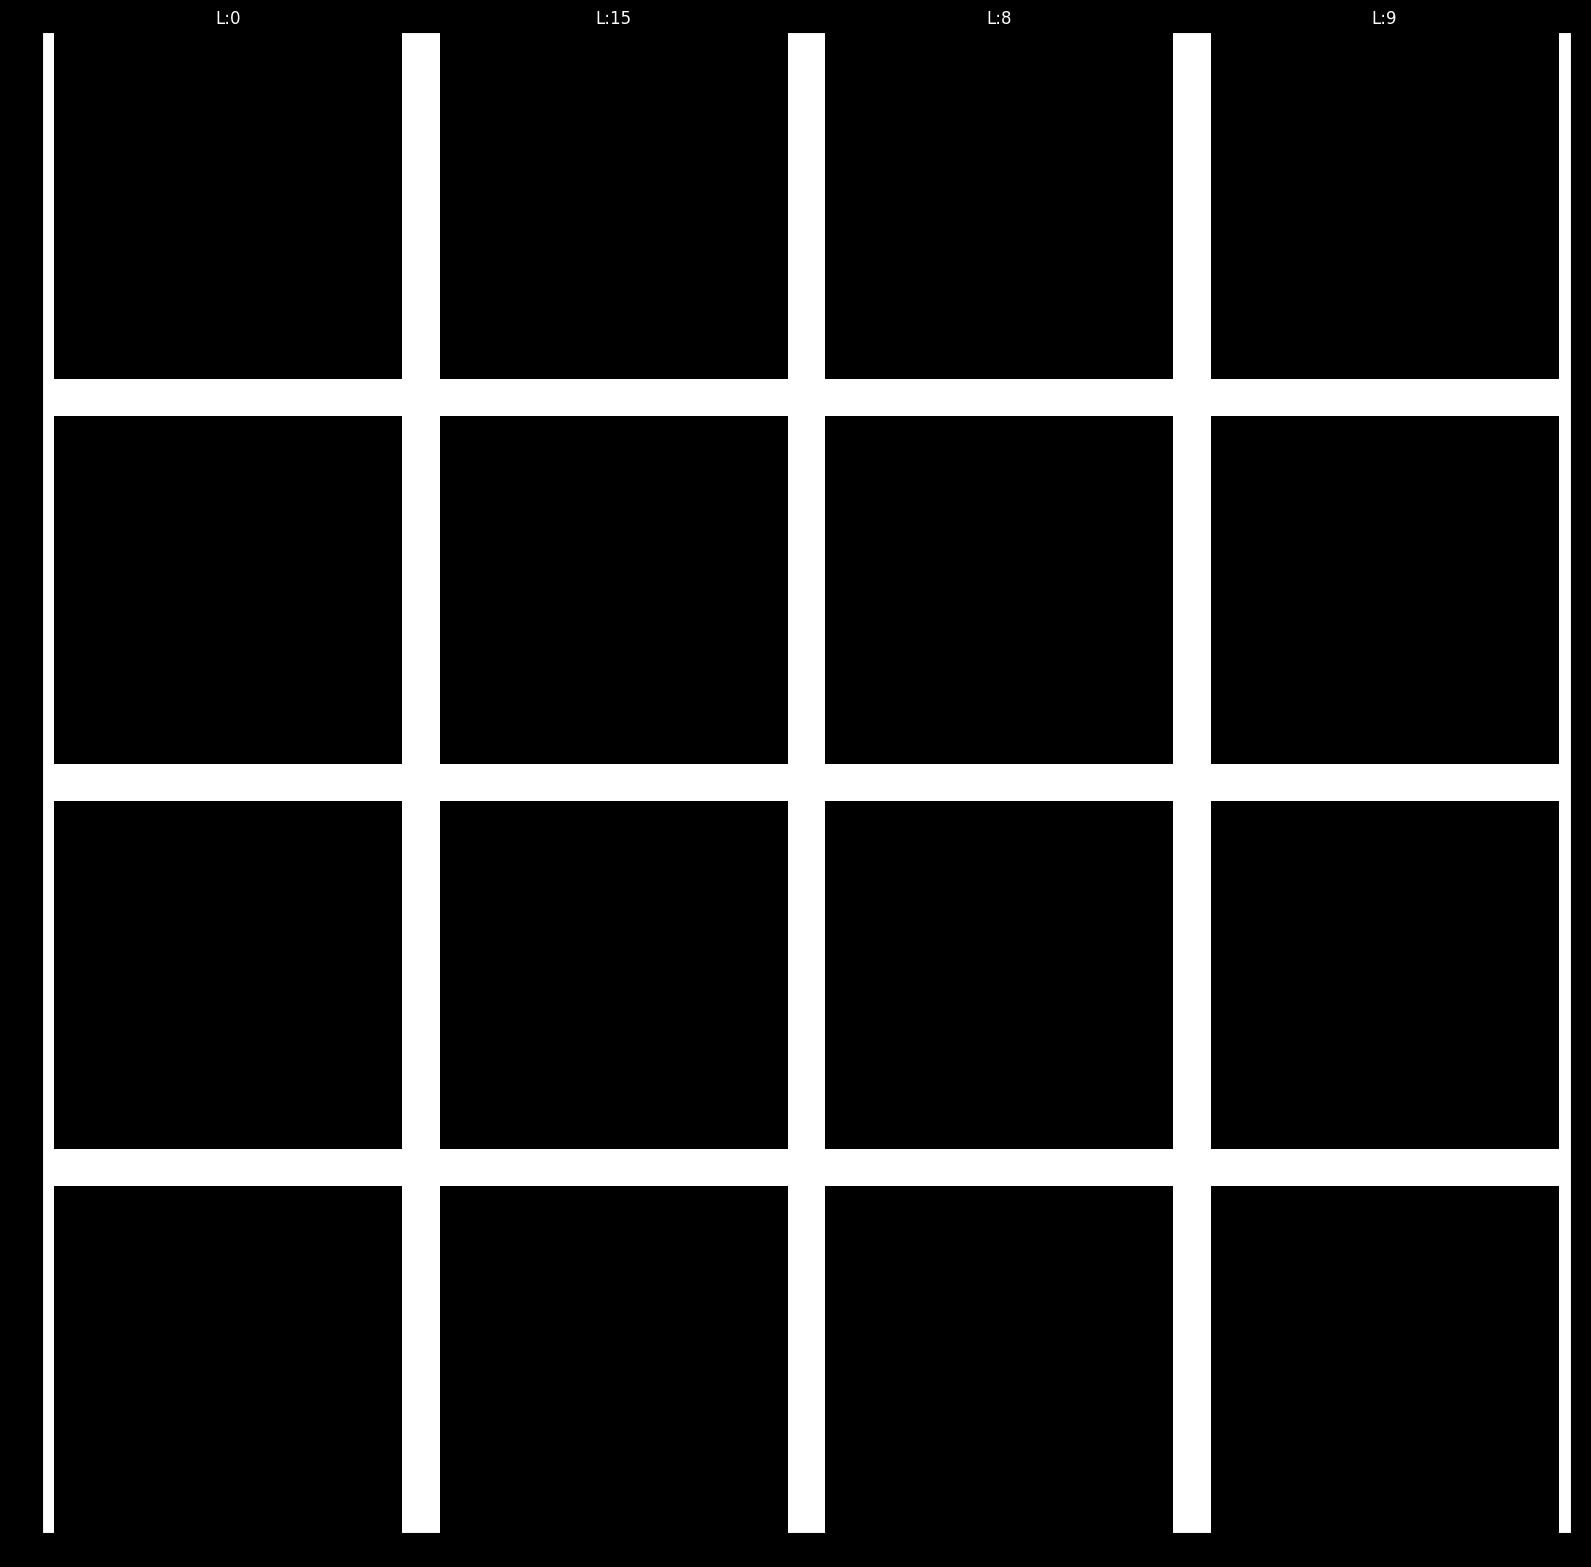

In [ ]:
import math

max_filters = 16
num_filter = features.shape[-1]

if max_filters > num_filter:
    max_filters = num_filter

col_num = int(math.sqrt(max_filters))
row_num = max_filters // col_num
if max_filters % col_num != 0:
    row_num += 1

idxs = random.sample(range(num_filter), max_filters)

fig = plt.figure(figsize=(16, 16), facecolor='black')
plt.title(f"{target_model.layers[target_layer_num].name}")

for i, idx in enumerate(idxs):
    plt.subplot(row_num, col_num, i+1)
    plt.imshow(features[0, :, :, idx], cmap='gray')
    plt.gca().set_title(f"L:{idx}", color='white')
    plt.axis('off')

plt.tight_layout()
plt.show()
